# Step 0 - Setup and Imports

In [1]:

from extract_features import process_dataset
from visualization import signal_viewer
from pathlib import Path
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from imu_pipeline import IMUPipeline, signal_features
# ks_2samp
from scipy.stats import ks_2samp
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
)

In [2]:
CANONICAL_CLASSES = ["collision", "normal"]

# Step 1 - Generate Inference Features

In [3]:
process_dataset("inference")

[INFO] No label CSV found for 'inference' – proceeding without labels.

Processing 'inference' dataset...


100%|██████████| 473/473 [00:02<00:00, 216.13it/s]

Processed 473 samples to data/inference.csv


,x_mean,x_std,x_max,x_min,x_range,x_skew,x_kurtosis,x_n_peaks,x_energy,y_mean,...,temperature,humidity,altitude,session_id,firmware_version,calibration_status,battery_level,gps_accuracy,network_type,device_model
0,-1.017423,2.208189,3.777004,-10.004477,13.781481,-0.658316,2.010141,6,591.124531,0.675477,...,20,56,33,S238250,v1.2.3,ok,74,3.911899,5g,model_a
1,0.064070,0.143642,0.287473,-0.275590,0.563063,-0.442683,-1.153532,16,2.473785,0.016697,...,25,54,640,S768410,v1.3.0,pending,95,3.449207,4g,model_c
2,-0.607629,2.319787,8.488371,-10.221496,18.709867,0.109535,4.954180,5,575.062521,-1.043187,...,22,55,103,S885085,v1.2.3,pending,51,4.372168,wifi,model_b
3,0.810718,1.746104,5.144318,-6.113251,11.257569,-0.305047,3.035140,18,370.614479,0.142112,...,17,22,664,S487169,v1.2.4,ok,41,5.009501,5g,model_b
4,0.066337,2.206708,8.876968,-6.717497,15.594465,-0.173431,2.869159,9,487.395934,0.921517,...,20,49,238,S668533,v1.3.0,pending,67,8.398236,5g,model_b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,0.217939,2.547568,11.962388,-6.604442,18.566829,0.820073,4.033163,12,653.759981,2.275134,...,20,55,237,S130656,v1.2.3,recent,67,8.151750,wifi,model_b
469,0.859693,2.940574,12.714081,-12.852432,25.566513,-0.498107,6.695799,7,938.604875,-1.229983,...,17,56,648,S144861,v1.3.0,recent,34,5.036525,4g,model_a
470,0.064731,0.143980,0.302835,-0.213927,0.516762,-0.316536,-1.202000,14,2.492025,0.015717,...,22,56,336,S509702,v1.2.4,ok,55,4.636631,5g,model_c
471,-0.191251,2.814478,8.928538,-7.547454,16.475992,-0.088451,2.163719,7,795.786324,0.762645,...,27,77,417,S377462,v1.2.4,recent,77,7.954295,wifi,model_c


# Step 2 - Load Inference Set & Labels

In [4]:
inference_set = pd.read_csv("data/inference.csv")
labels = pd.read_csv("data/manual_annotation/inference_labels.csv")

## Step 3 - Merge Inferece Set with Labels

In [5]:
inference_set = inference_set.merge(labels, on="sample_id", how="left")

In [6]:
inference_set.columns

Index(['x_mean', 'x_std', 'x_max', 'x_min', 'x_range', 'x_skew', 'x_kurtosis',
       'x_n_peaks', 'x_energy', 'y_mean', 'y_std', 'y_max', 'y_min', 'y_range',
       'y_skew', 'y_kurtosis', 'y_n_peaks', 'y_energy', 'z_mean', 'z_std',
       'z_max', 'z_min', 'z_range', 'z_skew', 'z_kurtosis', 'z_n_peaks',
       'z_energy', 'mag_mean', 'mag_std', 'mag_max', 'max_delta_mag',
       'sudden_change_score', 'x_fft_max', 'x_fft_mean', 'y_fft_max',
       'y_fft_mean', 'z_fft_max', 'z_fft_mean', 'xy_corr', 'xz_corr',
       'yz_corr', 'sample_id', 'sensor_source', 'timestamp', 'weather',
       'driver_id', 'vehicle_type', 'speed_bin', 'road_type', 'time_of_day',
       'temperature', 'humidity', 'altitude', 'session_id', 'firmware_version',
       'calibration_status', 'battery_level', 'gps_accuracy', 'network_type',
       'device_model', 'label'],
      dtype='object')

# Step 4 - Save Inference Set to CSV

In [7]:
inference_set.to_csv("data/inference_with_labels.csv", index=False)

# Step 5 – Visualize IMU Signals (Optional but Recommended)

In [8]:
signal_viewer(
    data_dir=Path('data/raw/train'),
    labels_csv=Path('data/train.csv')
)

In [9]:
signal_viewer(data_dir=Path("data/raw/test"), labels_csv=Path("data/test.csv"))

In [10]:
signal_viewer(data_dir=Path("data/raw/inference"), labels_csv=Path("data/inference_with_labels.csv"))

# Step 6 - Run Model Predictions

## Step 6.1 - Load Data and Model

In [11]:
df_inf = pd.read_csv("data/inference_with_labels.csv")
df_test = pd.read_csv("data/test.csv")
model = joblib.load("models/imu_pipeline.pkl")

In [12]:
model_classes = list(model.label_encoder.classes_)

if model_classes != CANONICAL_CLASSES:
    reindex = [model_classes.index(c) for c in CANONICAL_CLASSES]

    def aligned_proba(x):
        return model.predict_proba(x)[:, reindex]

else:
    aligned_proba = model.predict_proba

In [13]:
df_inf.columns, df_test.columns

(Index(['x_mean', 'x_std', 'x_max', 'x_min', 'x_range', 'x_skew', 'x_kurtosis',
        'x_n_peaks', 'x_energy', 'y_mean', 'y_std', 'y_max', 'y_min', 'y_range',
        'y_skew', 'y_kurtosis', 'y_n_peaks', 'y_energy', 'z_mean', 'z_std',
        'z_max', 'z_min', 'z_range', 'z_skew', 'z_kurtosis', 'z_n_peaks',
        'z_energy', 'mag_mean', 'mag_std', 'mag_max', 'max_delta_mag',
        'sudden_change_score', 'x_fft_max', 'x_fft_mean', 'y_fft_max',
        'y_fft_mean', 'z_fft_max', 'z_fft_mean', 'xy_corr', 'xz_corr',
        'yz_corr', 'sample_id', 'sensor_source', 'timestamp', 'weather',
        'driver_id', 'vehicle_type', 'speed_bin', 'road_type', 'time_of_day',
        'temperature', 'humidity', 'altitude', 'session_id', 'firmware_version',
        'calibration_status', 'battery_level', 'gps_accuracy', 'network_type',
        'device_model', 'label'],
       dtype='object'),
 Index(['x_mean', 'x_std', 'x_max', 'x_min', 'x_range', 'x_skew', 'x_kurtosis',
        'x_n_peaks', 'x_ene

In [14]:
df_inf.shape, df_test.shape

((473, 61), (200, 61))

## Step 6.2 - Missing Values

In [15]:
missing_vals_inf = df_inf.isnull().sum()
if missing_vals_inf.sum() > 0:
    print("Missing values detected:")
    print(missing_vals_inf[missing_vals_inf > 0])

missing_vals_test = df_test.isnull().sum()
if missing_vals_test.sum() > 0:
    print("Missing values detected:")
    print(missing_vals_test[missing_vals_test > 0])

## Step 6.3 - Run Inference Inference Set

In [16]:
inf_probs = aligned_proba(df_inf)
inf_preds = model.predict(df_inf)

In [17]:
inf_preds.shape, inf_probs.shape

((473,), (473, 2))

In [18]:
inf_preds[:10], inf_probs[:10]

(array(['collision', 'normal', 'collision', 'collision', 'collision',
        'collision', 'collision', 'collision', 'collision', 'collision'],
       dtype=object),
 array([[0.91, 0.09],
        [0.14, 0.86],
        [0.96, 0.04],
        [0.97, 0.03],
        [0.99, 0.01],
        [0.96, 0.04],
        [0.95, 0.05],
        [0.9 , 0.1 ],
        [0.93, 0.07],
        [0.95, 0.05]]))

## Step 6.4 - Run Inference Test Set

In [19]:
test_probs = aligned_proba(df_test)
test_preds = model.predict(df_test)

In [20]:
test_preds.shape, test_probs.shape

((200,), (200, 2))

In [21]:
test_preds[:10], test_probs[:10]

(array(['normal', 'normal', 'normal', 'collision', 'collision',
        'collision', 'normal', 'normal', 'normal', 'collision'],
       dtype=object),
 array([[0.13, 0.87],
        [0.02, 0.98],
        [0.02, 0.98],
        [0.99, 0.01],
        [0.99, 0.01],
        [1.  , 0.  ],
        [0.02, 0.98],
        [0.23, 0.77],
        [0.16, 0.84],
        [1.  , 0.  ]]))

# Step 7 - Save Predictions to CSV

## Step 7.1 - Save Inference Set Predictions

In [22]:
df_inf["predicted_label"] = inf_preds
df_inf["predicted_prob"] = inf_probs[:, 0]

df_inf.to_csv("data/predictions/inference_set.csv", index=False)

## Step 7.2 - Save Test Set Predictions

In [23]:
df_test["predicted_label"] = test_preds
df_test["predicted_prob"] = test_probs[:, 0]

df_test.to_csv("data/predictions/test_set.csv", index=False)

# Step 8 - Evaluation Metrics

## Step 8.1 - Accuracy

In [24]:
inf_accuracy = accuracy_score(df_inf["label"], df_inf["predicted_label"])

test_accuracy = accuracy_score(df_test["label"], df_test["predicted_label"])

inf_accuracy, test_accuracy

(0.6448202959830867, 0.945)

## Step 8.2 - F1, Precision, Recall

In [25]:
inf_f1, inf_precision, inf_recall, _ = precision_recall_fscore_support(
    df_inf["label"], df_inf["predicted_label"], average="weighted"
)

test_f1, test_precision, test_recall, _ = precision_recall_fscore_support(
    df_test["label"], df_test["predicted_label"], average="weighted"
)

(inf_f1, inf_precision, inf_recall), (test_f1, test_precision, test_recall)

((0.7384072301272457, 0.6448202959830867, 0.606589098473726),
 (0.9504504504504504, 0.945, 0.9448331201885705))

## Step 8.3 - Confusion Matrix

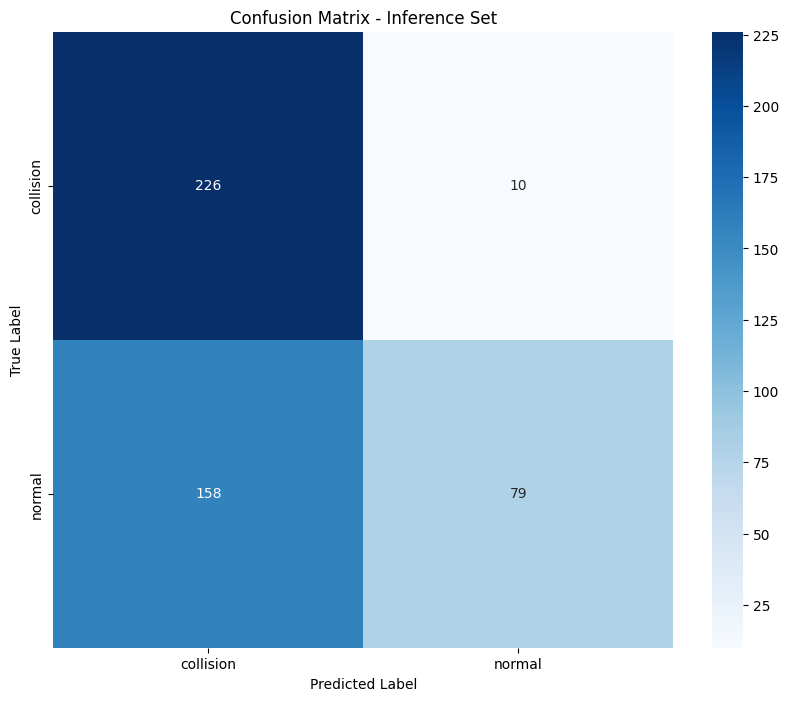

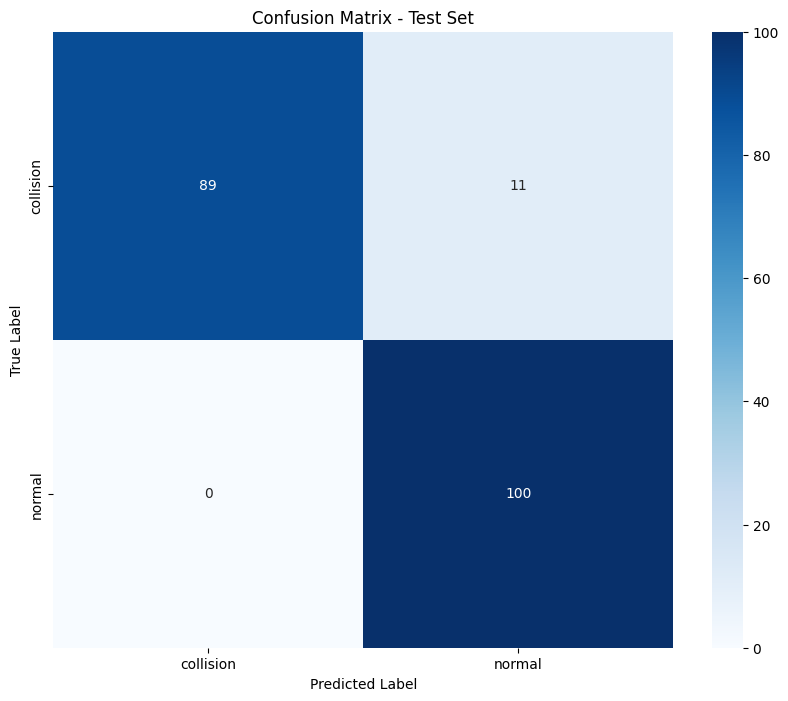

In [26]:
inf_cm = confusion_matrix(
    df_inf["label"], df_inf["predicted_label"], labels=CANONICAL_CLASSES
)
test_cm = confusion_matrix(
    df_test["label"], df_test["predicted_label"], labels=CANONICAL_CLASSES
)

plt.figure(figsize=(10, 8))
sns.heatmap(
    inf_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=CANONICAL_CLASSES,
    yticklabels=CANONICAL_CLASSES)

plt.title("Confusion Matrix - Inference Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(
    test_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=CANONICAL_CLASSES,
    yticklabels=CANONICAL_CLASSES
)
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Step 9 - Exploratory Data Analysis (EDA)

## Step 9.1 - Ground Truth & Label Distribution Inferece vs Test

In [ ]:
inf_label_counts = df_inf["label"].value_counts(normalize=True)
test_label_counts = df_test["label"].value_counts(normalize=True)

inf_pred_counts = df_inf["predicted_label"].value_counts(normalize=True)
test_pred_counts = df_test["predicted_label"].value_counts(normalize=True)

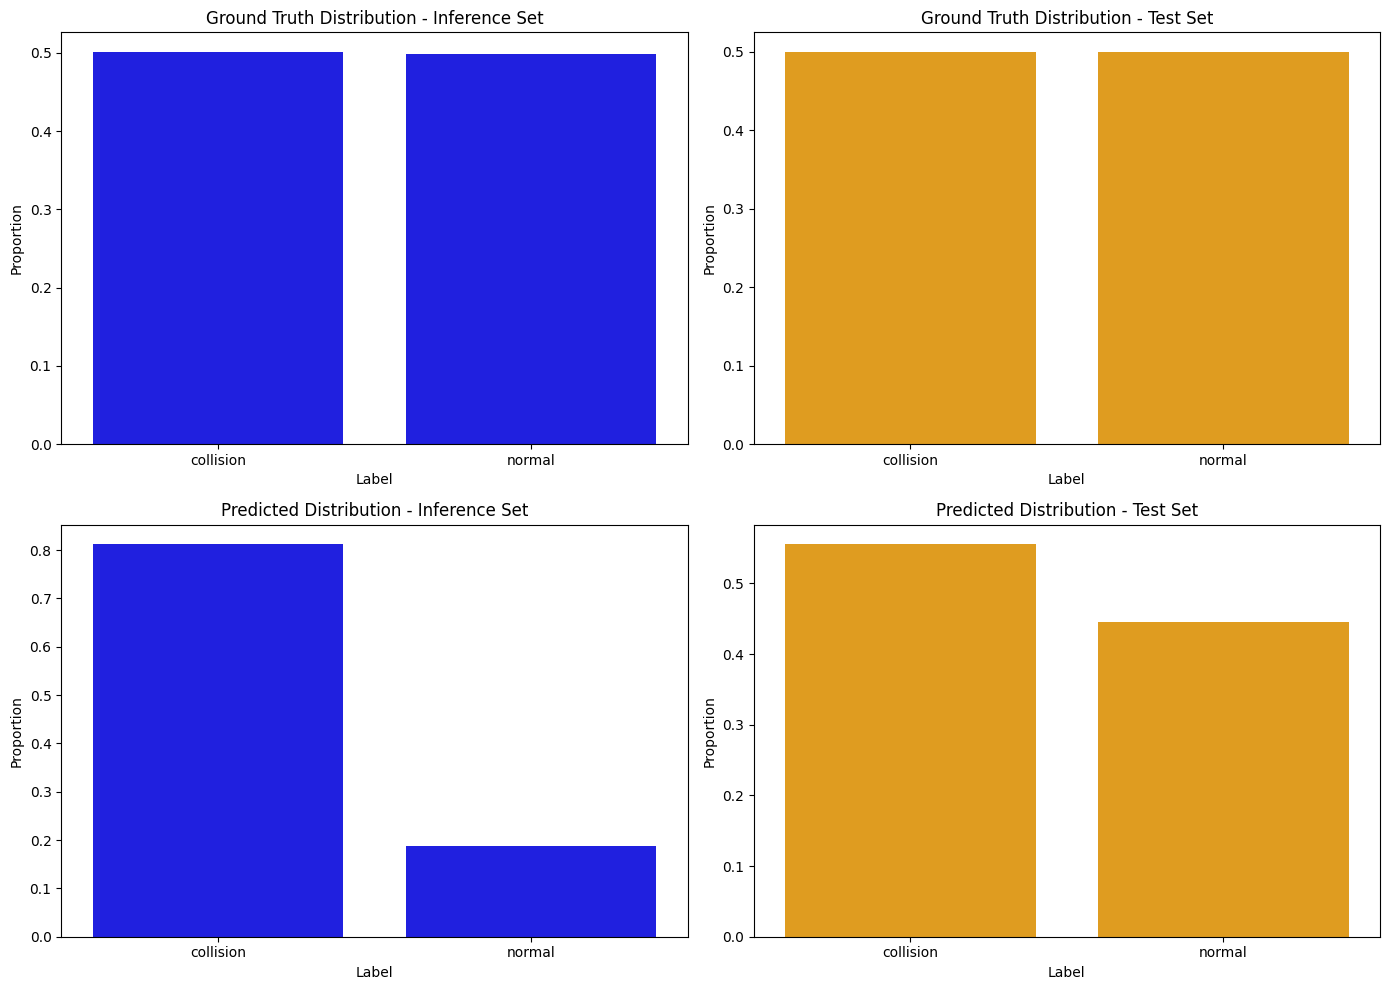

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
sns.barplot(x=CANONICAL_CLASSES, y=inf_label_counts, ax=axes[0], color='blue')
axes[0].set_title("Ground Truth Distribution - Inference Set")
axes[0].set_ylabel("Proportion")
axes[0].set_xlabel("Label")

sns.barplot(x=CANONICAL_CLASSES, y=test_label_counts, ax=axes[1], color='orange')
axes[1].set_title("Ground Truth Distribution - Test Set")
axes[1].set_ylabel("Proportion")
axes[1].set_xlabel("Label")

sns.barplot(x=CANONICAL_CLASSES, y=inf_pred_counts, ax=axes[2], color='blue')
axes[2].set_title("Predicted Distribution - Inference Set")
axes[2].set_ylabel("Proportion")
axes[2].set_xlabel("Label")

sns.barplot(x=CANONICAL_CLASSES, y=test_pred_counts, ax=axes[3], color='orange')
axes[3].set_title("Predicted Distribution - Test Set")
axes[3].set_ylabel("Proportion")
axes[3].set_xlabel("Label")

plt.tight_layout()
plt.show()

## Step 9.4 - Confidence Distribution

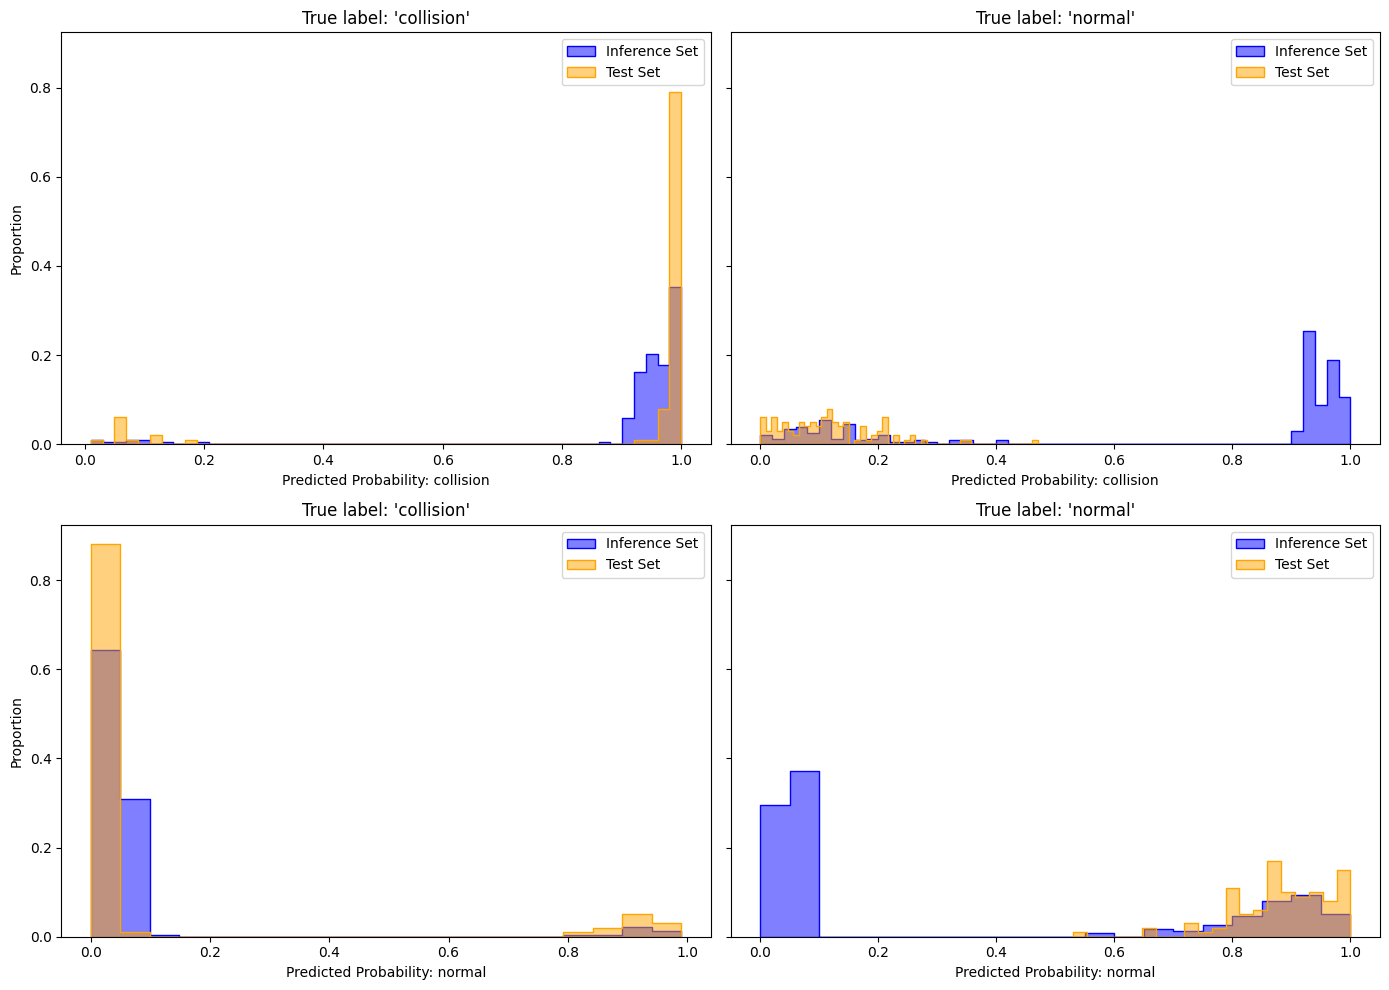

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)

for idx, label in enumerate(CANONICAL_CLASSES):

    sns.histplot(
        df_inf[df_inf["label"] == label]["predicted_prob"],
        label="Inference Set",
        color="blue",
        bins=50,
        stat="probability",
        alpha=0.5,
        ax=axes[0, idx],
        element="step",
    )
    sns.histplot(
        df_test[df_test["label"] == label]["predicted_prob"],
        label="Test Set",
        color="orange",
        bins=50,
        stat="probability",
        alpha=0.5,
        ax=axes[0, idx],
        element="step",
    )
    axes[0, idx].set_title(f"True label: '{label}'")
    axes[0, idx].set_xlabel("Predicted Probability: collision")
    axes[0, idx].set_ylabel("Proportion")
    axes[0, idx].legend()

    sns.histplot(
        1 - df_inf[df_inf["label"] == label]["predicted_prob"],
        label="Inference Set",
        color="blue",
        bins=20,
        stat="probability",
        alpha=0.5,
        ax=axes[1, idx],
        element="step",
    )
    sns.histplot(
        1 - df_test[df_test["label"] == label]["predicted_prob"],
        label="Test Set",
        color="orange",
        bins=20,
        stat="probability",
        alpha=0.5,
        ax=axes[1, idx],
        element="step",
    )
    axes[1, idx].set_title(f"True label: '{label}'")
    axes[1, idx].set_xlabel("Predicted Probability: normal")
    axes[1, idx].set_ylabel("Proportion")
    axes[1, idx].legend()

plt.tight_layout()
plt.show()

## A quick change we could make to fix the model inference on the inference set is to basically have a treshold on the model predictions for collision. If the collision probability we need to reject the prediction and set it to normal.

## Step 9.3 - Feature Distribution

In [30]:
df_inf.columns

Index(['x_mean', 'x_std', 'x_max', 'x_min', 'x_range', 'x_skew', 'x_kurtosis',
       'x_n_peaks', 'x_energy', 'y_mean', 'y_std', 'y_max', 'y_min', 'y_range',
       'y_skew', 'y_kurtosis', 'y_n_peaks', 'y_energy', 'z_mean', 'z_std',
       'z_max', 'z_min', 'z_range', 'z_skew', 'z_kurtosis', 'z_n_peaks',
       'z_energy', 'mag_mean', 'mag_std', 'mag_max', 'max_delta_mag',
       'sudden_change_score', 'x_fft_max', 'x_fft_mean', 'y_fft_max',
       'y_fft_mean', 'z_fft_max', 'z_fft_mean', 'xy_corr', 'xz_corr',
       'yz_corr', 'sample_id', 'sensor_source', 'timestamp', 'weather',
       'driver_id', 'vehicle_type', 'speed_bin', 'road_type', 'time_of_day',
       'temperature', 'humidity', 'altitude', 'session_id', 'firmware_version',
       'calibration_status', 'battery_level', 'gps_accuracy', 'network_type',
       'device_model', 'label', 'predicted_label', 'predicted_prob'],
      dtype='object')

In [31]:
len(df_inf.columns)

63

In [ ]:
IGNORE_FEATURES = {
    "sample_id",
    "driver_id",
    "session_id",
    "label",
    "predicted_label",
    "predicted_prob",
    "timestamp",
}

SIGNAL_FEATURES = signal_features

NUMERICAL_FEATURES = [
    col for col in df_inf.columns if col not in IGNORE_FEATURES and col not in SIGNAL_FEATURES and pd.api.types.is_numeric_dtype(df_inf[col])
]

CATEGORICAL_FEATURES = [
    col for col in df_inf.columns if col not in IGNORE_FEATURES and col not in SIGNAL_FEATURES and col not in NUMERICAL_FEATURES
]

In [33]:
IGNORE_FEATURES, SIGNAL_FEATURES, NUMERICAL_FEATURES, CATEGORICAL_FEATURES

({'driver_id',
  'label',
  'predicted_label',
  'predicted_prob',
  'sample_id',
  'session_id',
  'timestamp'},
 ['x_mean',
  'x_std',
  'x_max',
  'x_min',
  'x_range',
  'x_skew',
  'x_kurtosis',
  'x_n_peaks',
  'x_energy',
  'y_mean',
  'y_std',
  'y_max',
  'y_min',
  'y_range',
  'y_skew',
  'y_kurtosis',
  'y_n_peaks',
  'y_energy',
  'z_mean',
  'z_std',
  'z_max',
  'z_min',
  'z_range',
  'z_skew',
  'z_kurtosis',
  'z_n_peaks',
  'z_energy',
  'mag_mean',
  'mag_std',
  'mag_max',
  'max_delta_mag',
  'sudden_change_score',
  'x_fft_max',
  'x_fft_mean',
  'y_fft_max',
  'y_fft_mean',
  'z_fft_max',
  'z_fft_mean',
  'xy_corr',
  'xz_corr',
  'yz_corr'],
 ['temperature', 'humidity', 'altitude', 'battery_level', 'gps_accuracy'],
 ['sensor_source',
  'weather',
  'vehicle_type',
  'speed_bin',
  'road_type',
  'time_of_day',
  'firmware_version',
  'calibration_status',
  'network_type',
  'device_model'])

In [34]:
sum(len(col) for col in [IGNORE_FEATURES, SIGNAL_FEATURES, NUMERICAL_FEATURES, CATEGORICAL_FEATURES])

63

In [ ]:
df_inf_ = df_inf.copy()
df_inf_["dataset"] = "inference"
df_test_ = df_test.copy()
df_test_["dataset"] = "test"
df_all = pd.concat([df_inf_, df_test_], axis=0, ignore_index=True)

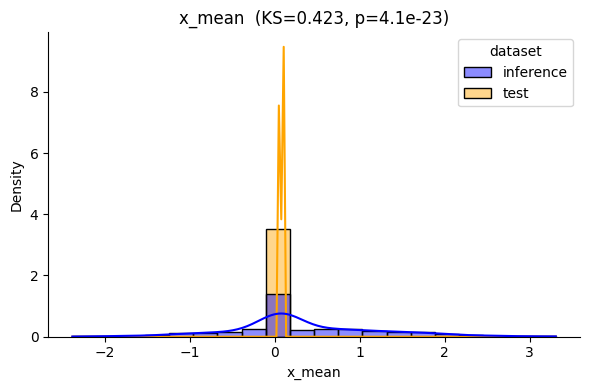

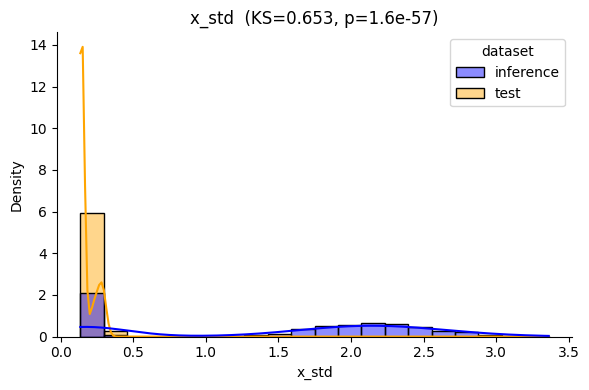

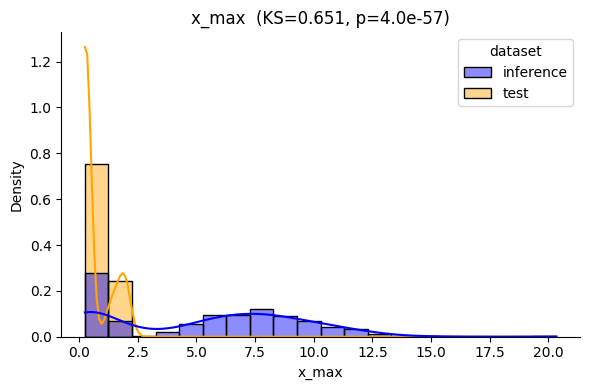

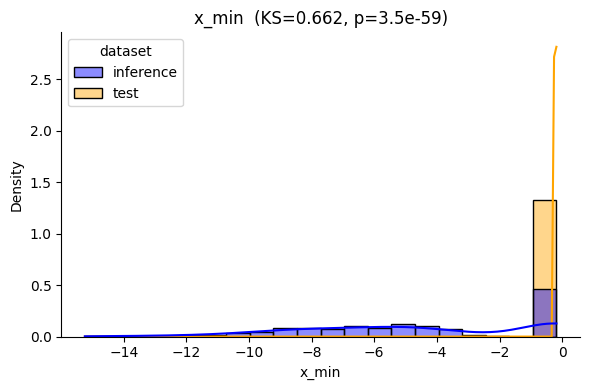

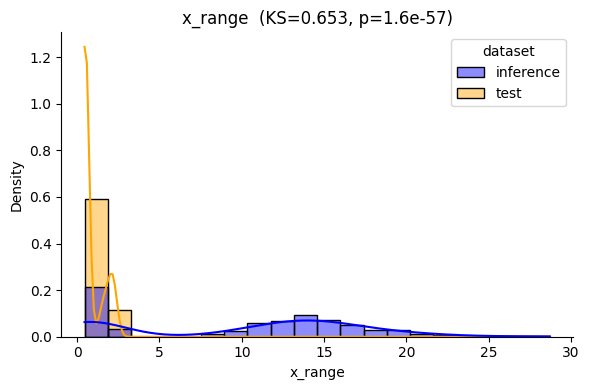

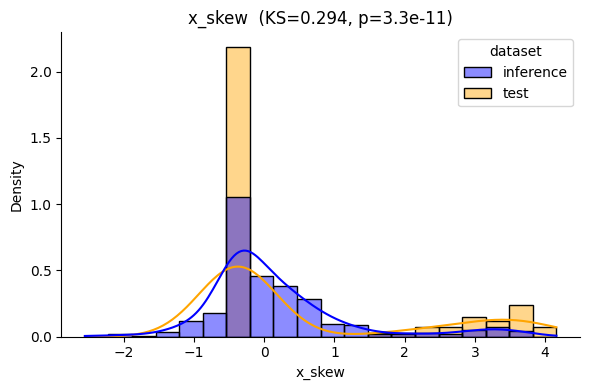

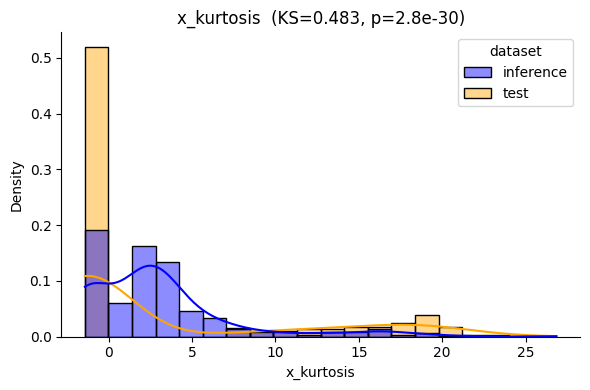

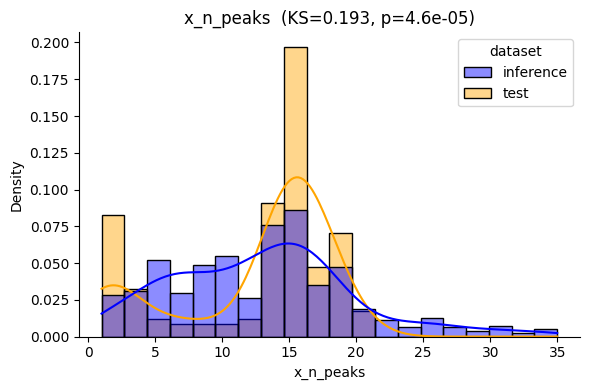

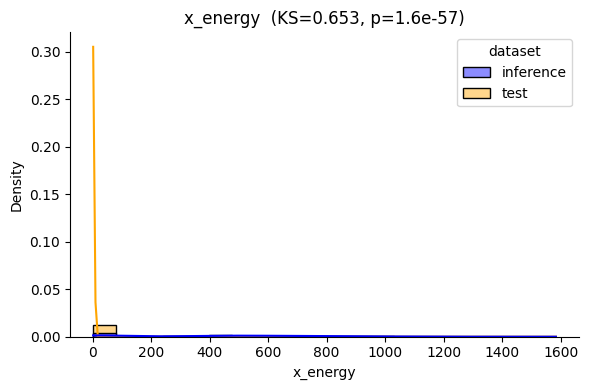

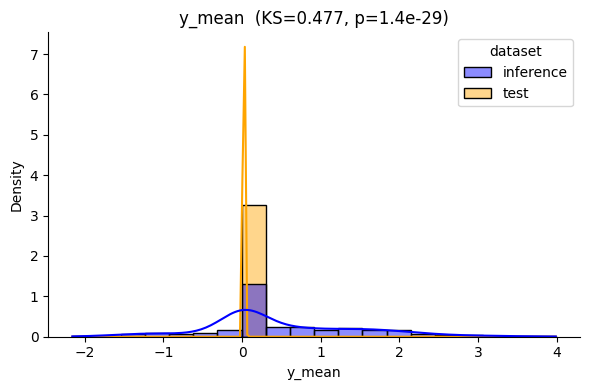

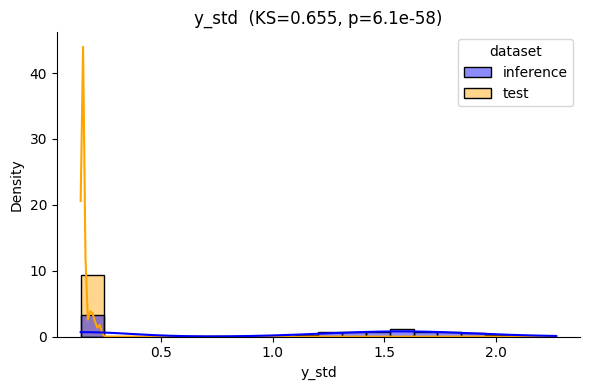

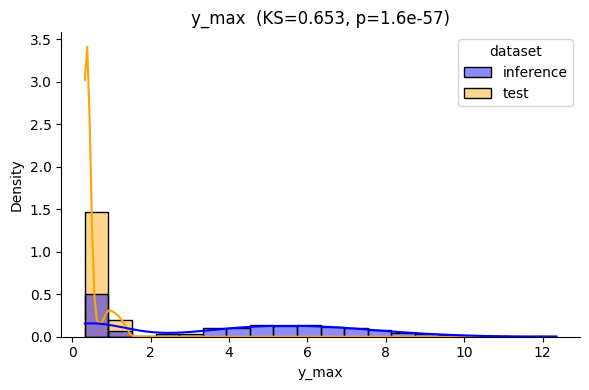

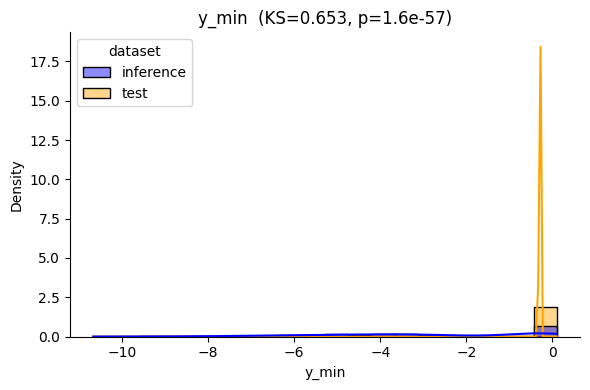

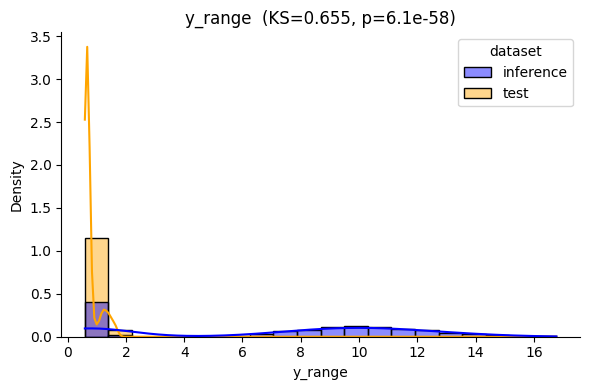

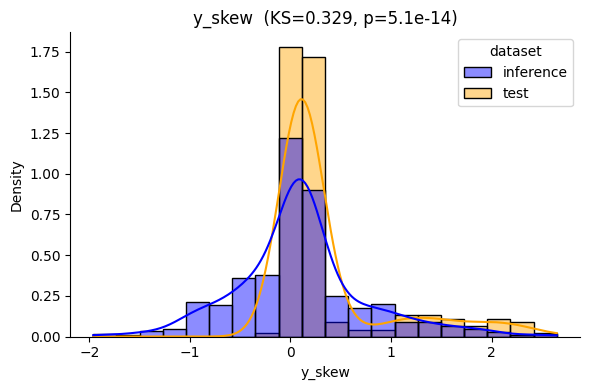

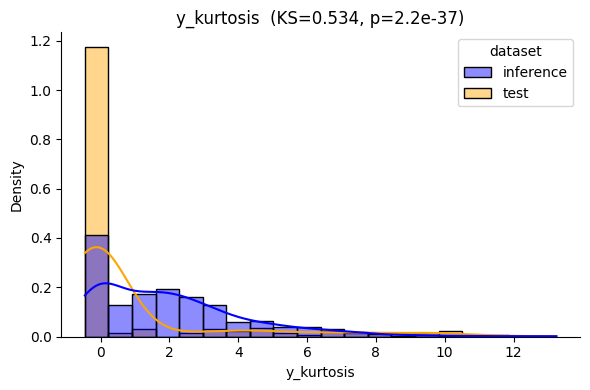

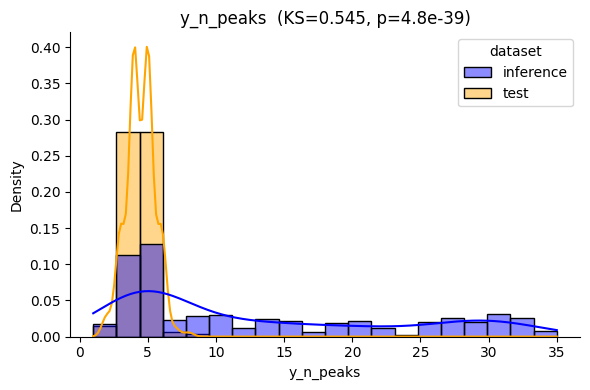

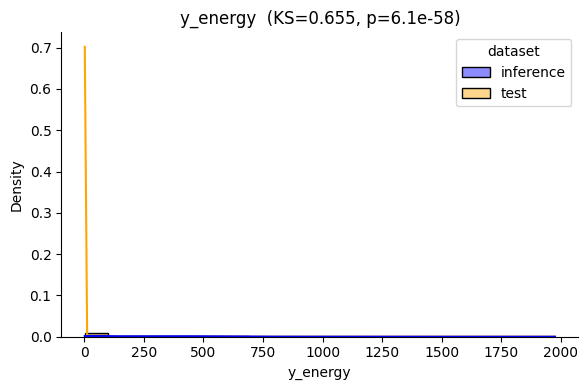

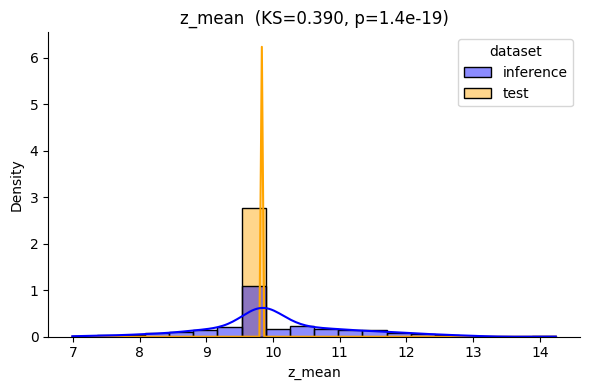

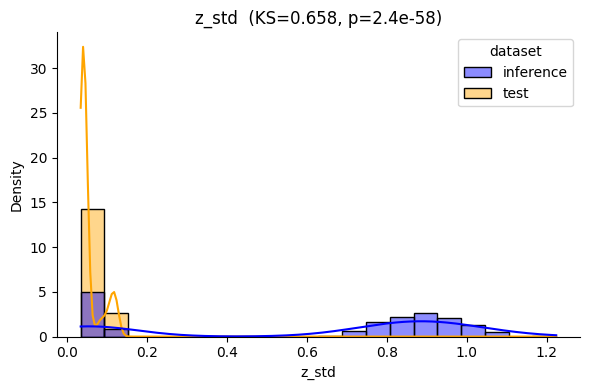

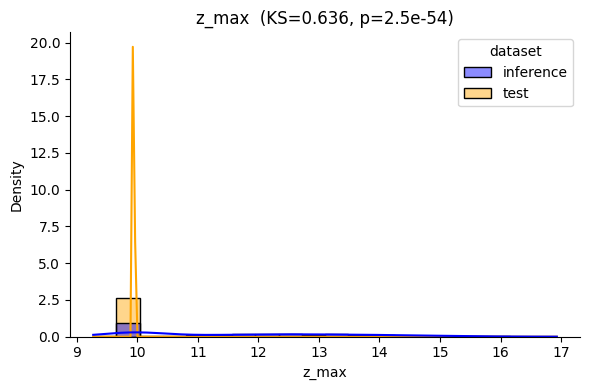

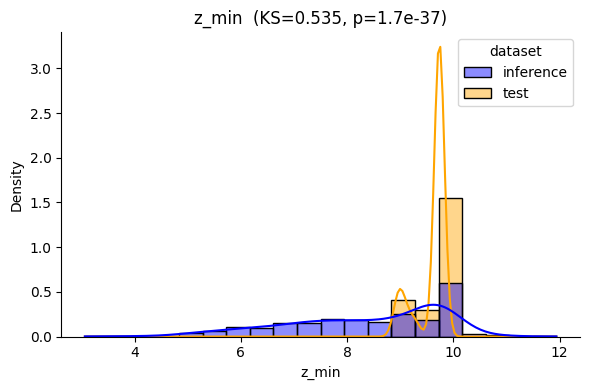

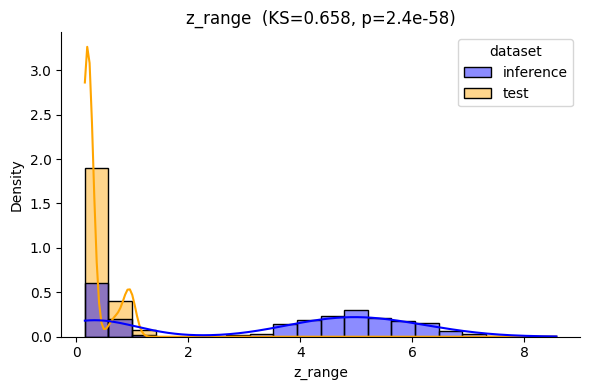

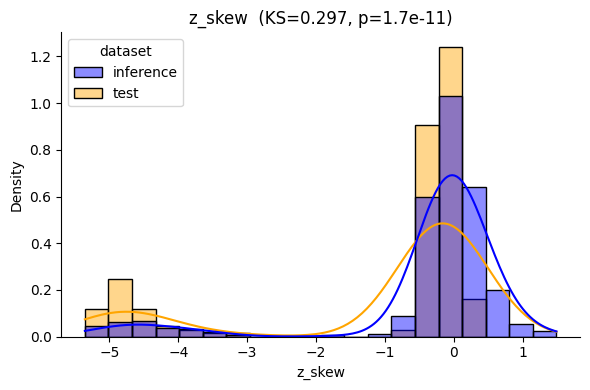

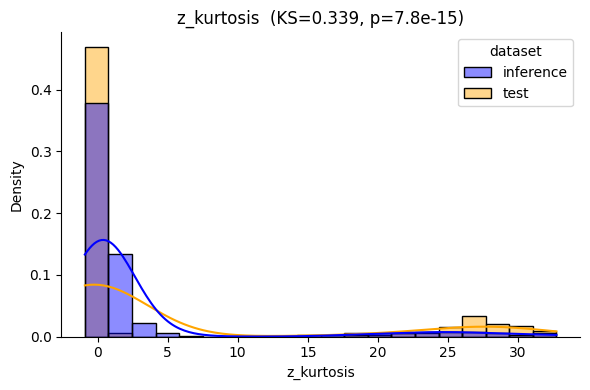

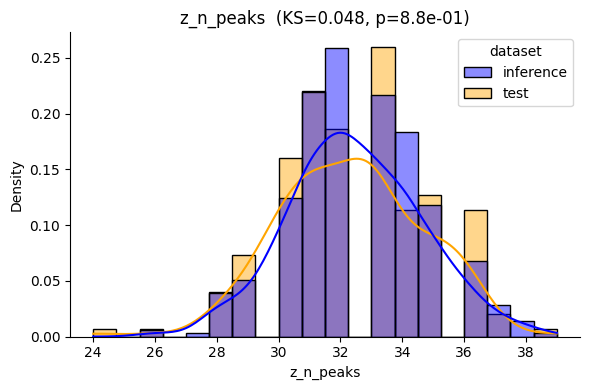

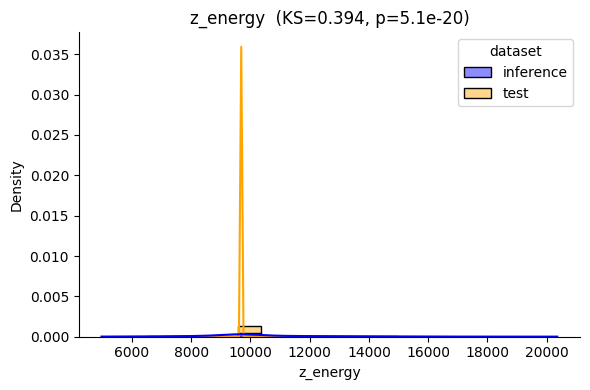

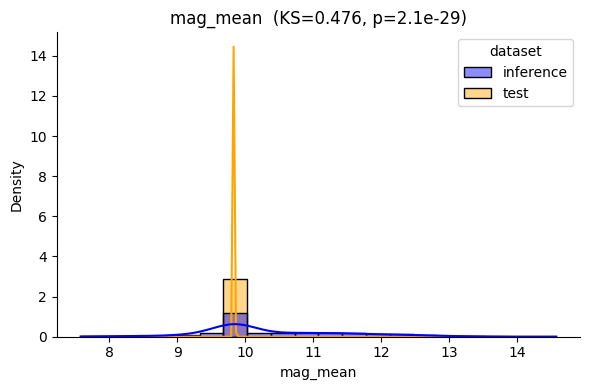

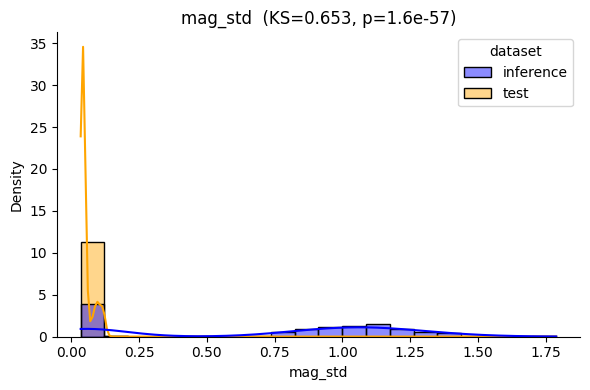

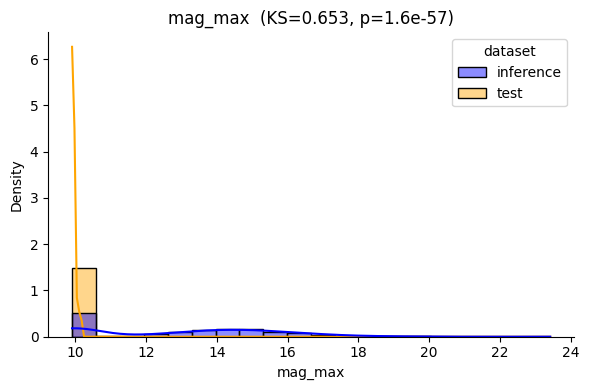

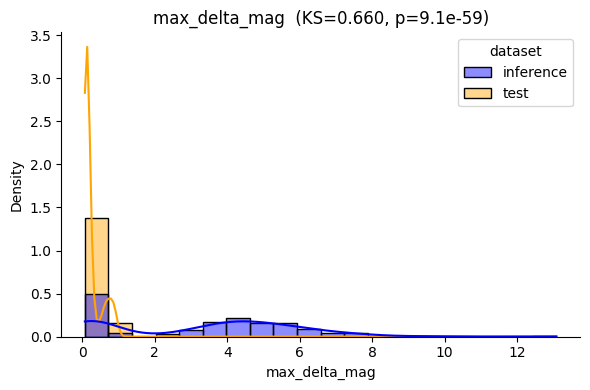

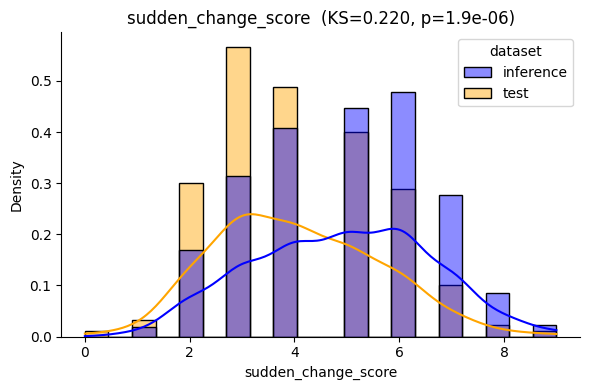

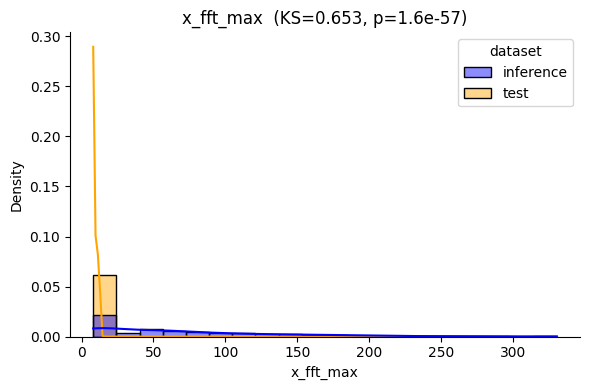

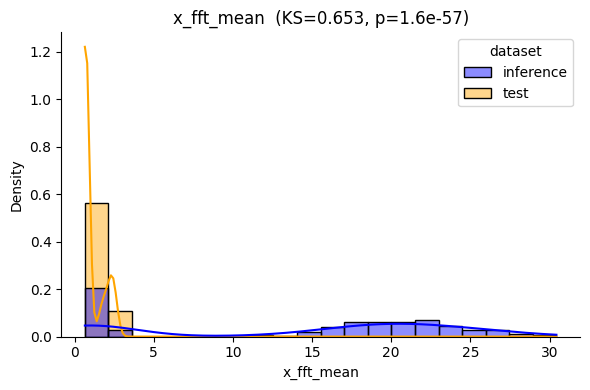

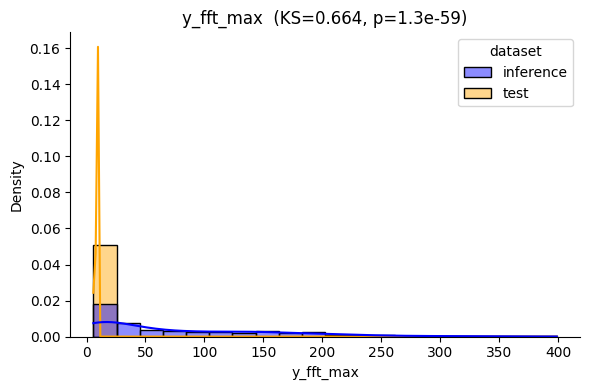

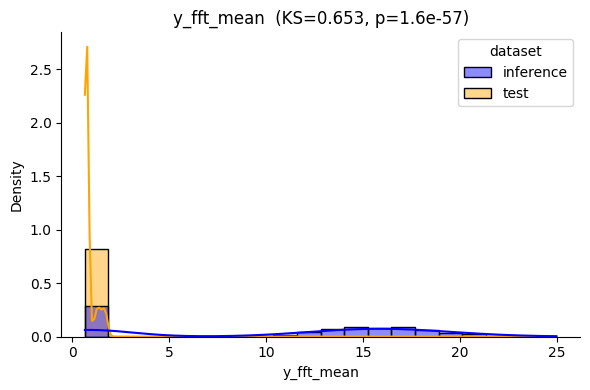

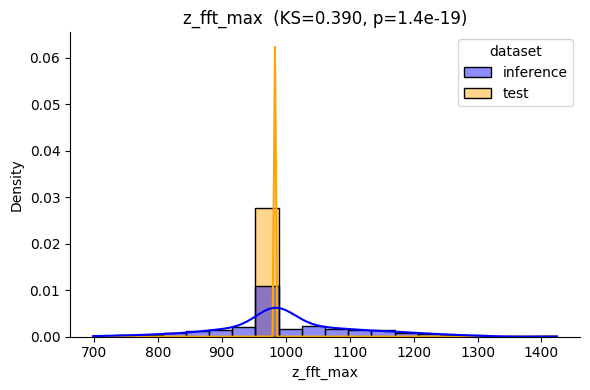

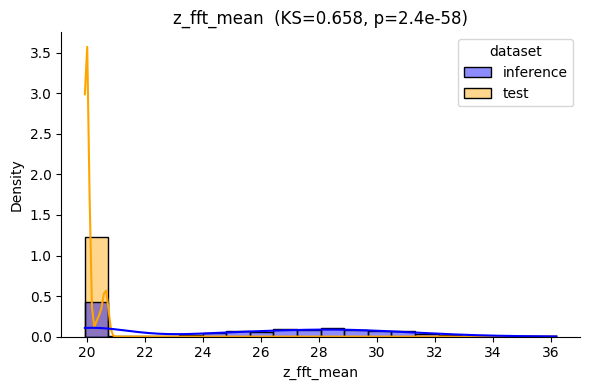

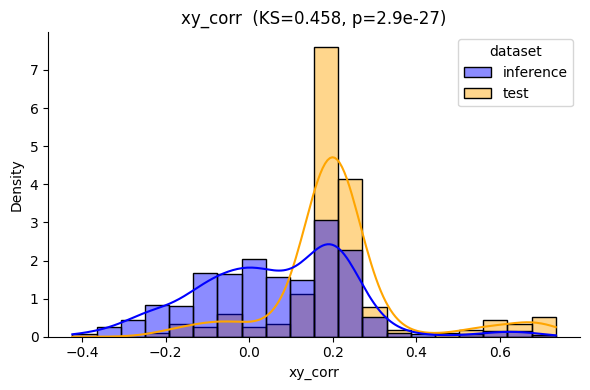

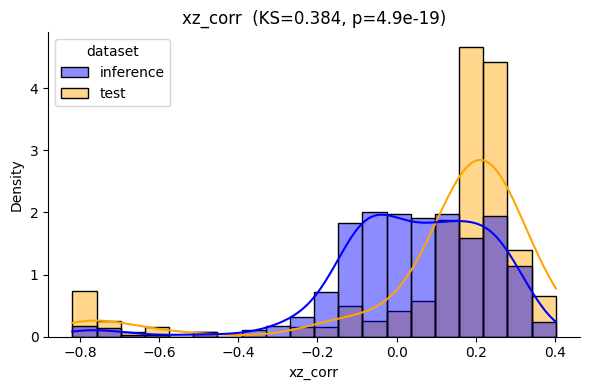

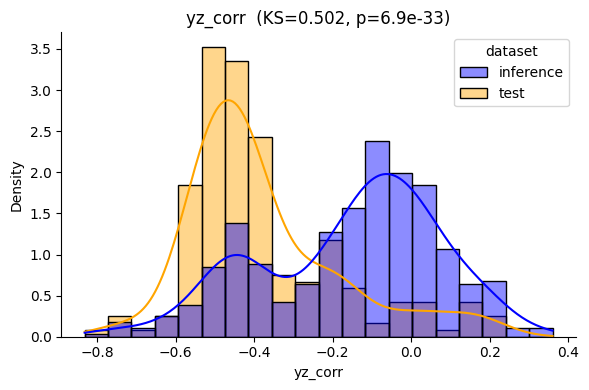

In [ ]:
def plot_numeric_feature(feature, bins=20, kde=True):
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.histplot(
        data=df_all,
        x=feature,
        hue="dataset",
        bins=bins,
        kde=kde,
        stat="density",
        common_norm=False,
        palette={"inference": "blue", "test": "orange"},
        ax=ax,
        alpha=0.45,
    )

    stat, p = ks_2samp(df_inf_[feature].dropna(), df_test_[feature].dropna())
    ax.set_title(f"{feature}  (KS={stat:.3f}, p={p:.1e})")
    ax.set_xlabel(feature)
    ax.set_ylabel("Density")
    sns.despine()
    plt.tight_layout()
    plt.show()
    return stat, p


vals = []
for feature in SIGNAL_FEATURES:
    stat, p = plot_numeric_feature(feature)
    vals.append((feature, stat, p))

vals_df = pd.DataFrame(vals, columns=["feature", "ks_statistic", "p_value"])
vals_df.to_csv("data/ks_results/signal_features.csv", index=False)

In [37]:
vals_df

,feature,ks_statistic,p_value
0,x_mean,0.422833,4.134064e-23
1,x_std,0.653277,1.560487e-57
2,x_max,0.651163,3.989000e-57
3,x_min,0.661734,3.489473e-59
4,x_range,0.653277,1.560487e-57
5,x_skew,0.293710,3.265706e-11
6,x_kurtosis,0.482643,2.775047e-30
7,x_n_peaks,0.192970,4.601805e-05
8,x_energy,0.653277,1.560487e-57
9,y_mean,0.477030,1.446030e-29


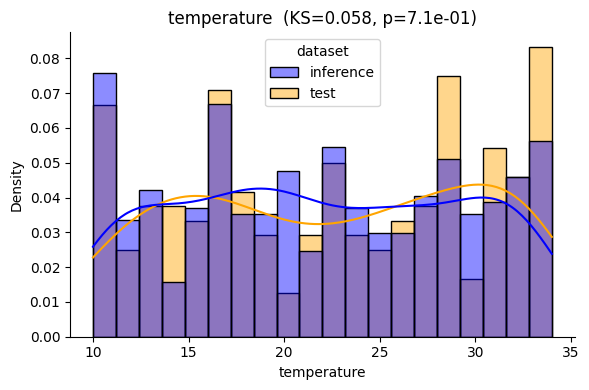

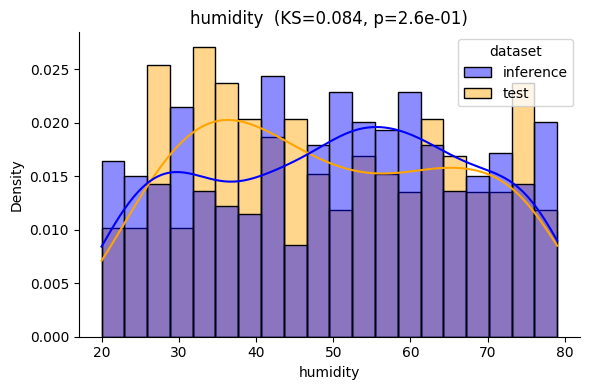

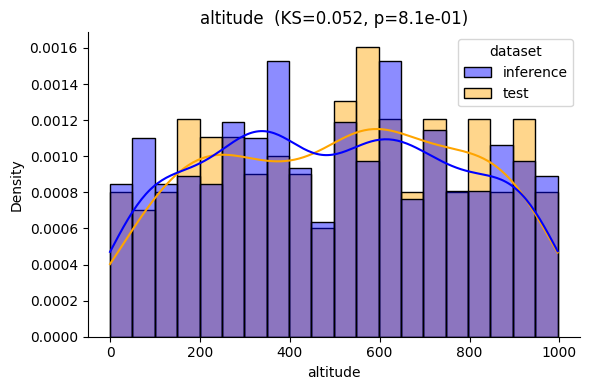

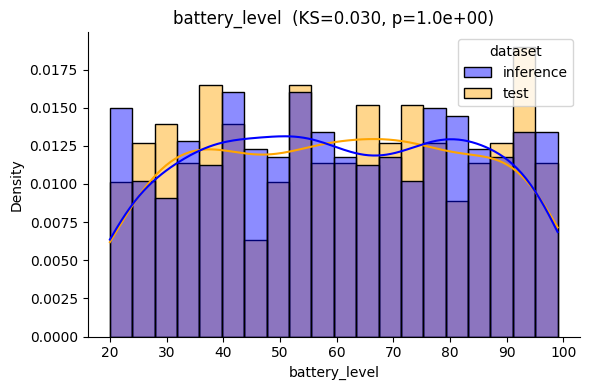

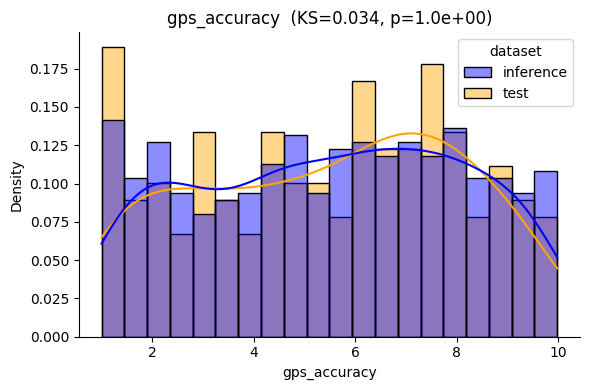

In [38]:
vals = []
# Plot all signal features
for feature in NUMERICAL_FEATURES:
    stat, p = plot_numeric_feature(feature)
    vals.append((feature, stat, p))

vals_df = pd.DataFrame(vals, columns=["feature", "ks_statistic", "p_value"])
vals_df.to_csv("data/ks_results/numerical_features.csv", index=False)

In [39]:
vals_df

,feature,ks_statistic,p_value
0,temperature,0.057706,0.709768
1,humidity,0.084080,0.255401
2,altitude,0.052262,0.812793
3,battery_level,0.030148,0.999020
4,gps_accuracy,0.033732,0.995123


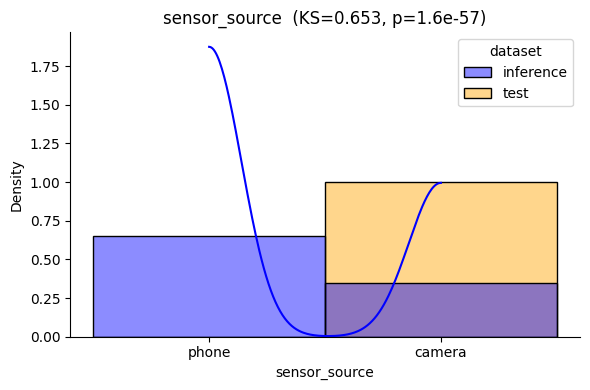

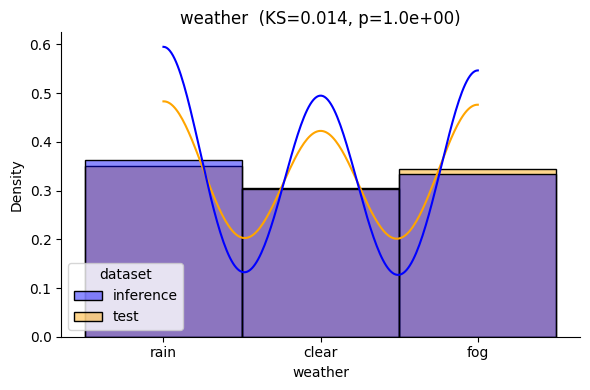

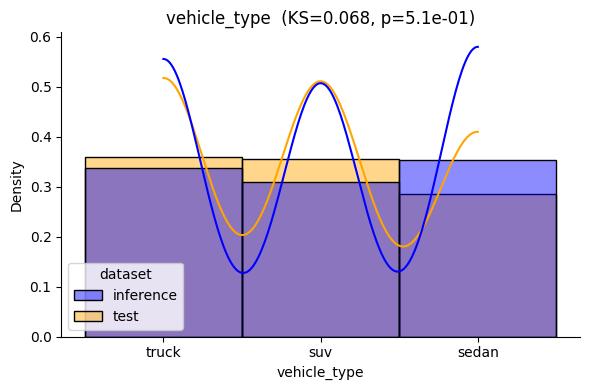

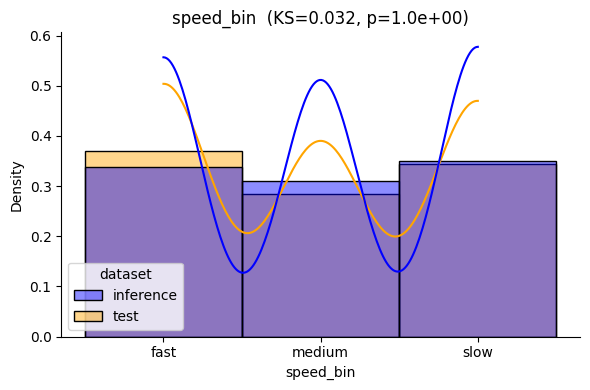

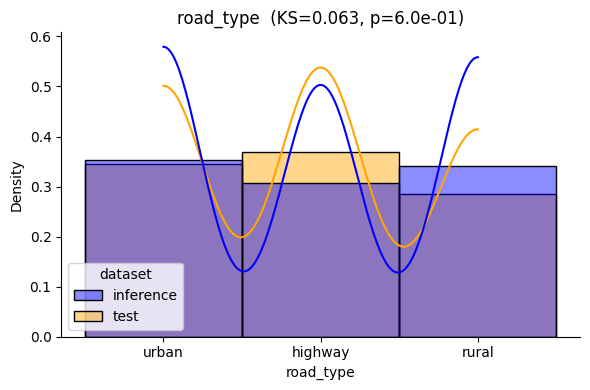

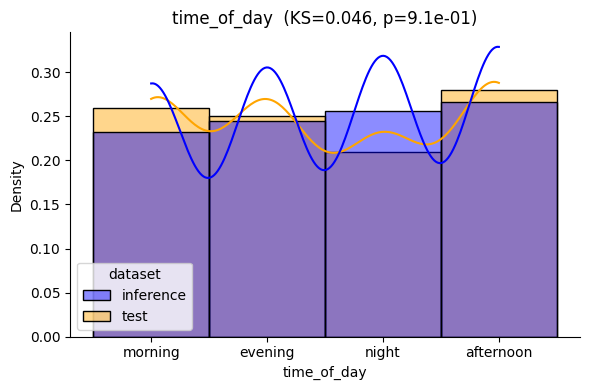

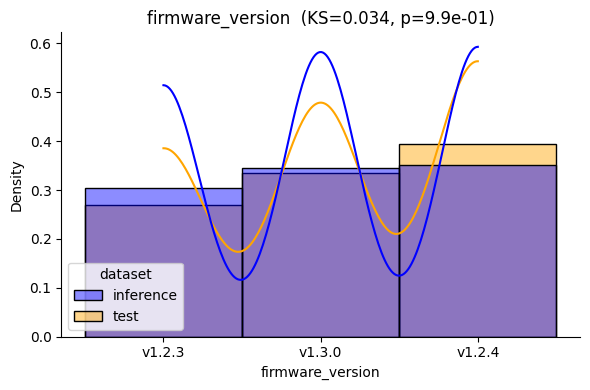

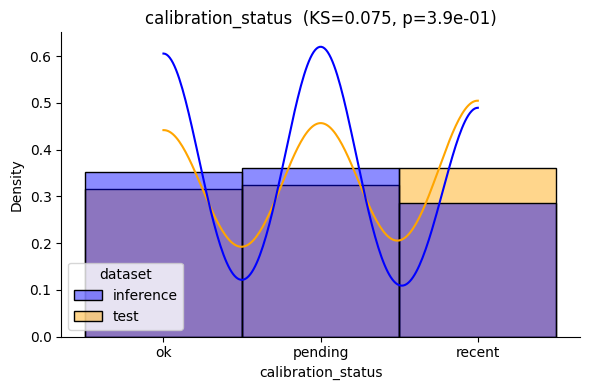

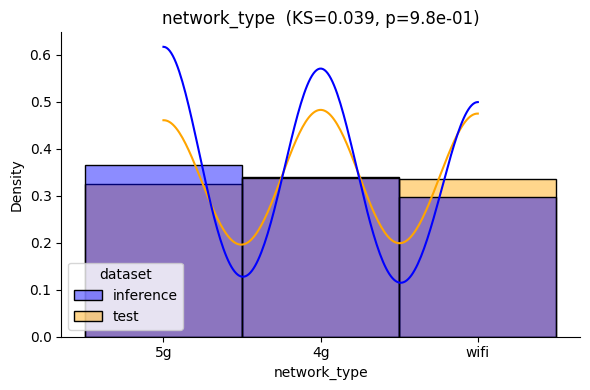

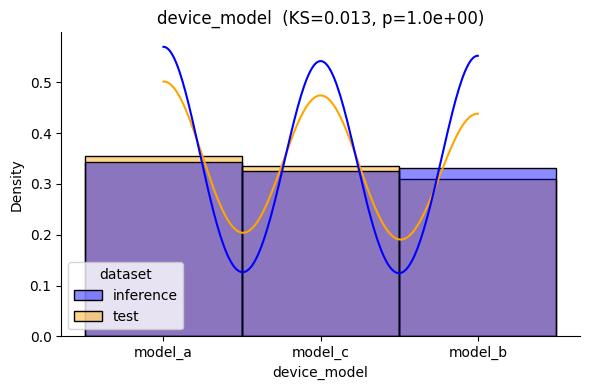

In [ ]:
vals = []

for feature in CATEGORICAL_FEATURES:
    stat, p = plot_numeric_feature(feature)
    vals.append((feature, stat, p))

vals_df = pd.DataFrame(vals, columns=["feature", "ks_statistic", "p_value"])
vals_df.to_csv("data/ks_results/categorical_features.csv", index=False)

In [41]:
vals_df

,feature,ks_statistic,p_value
0,sensor_source,0.653277,1.560487e-57
1,weather,0.013636,1.000000e+00
2,vehicle_type,0.068066,5.059434e-01
3,speed_bin,0.031734,9.978706e-01
4,road_type,0.063446,5.952143e-01
5,time_of_day,0.045814,9.127334e-01
6,firmware_version,0.034440,9.936888e-01
7,calibration_status,0.074588,3.909777e-01
8,network_type,0.039017,9.757436e-01
9,device_model,0.012505,1.000000e+00


#### Question 1: What do you observe when comparing the model’s predictions on the new data to its known performance?
#### Answer:
##### - The model is heavily predicting “collision” on the inference set, in many cases with very high probabilities (≥ 0.9 or 1.0).
##### - By contrast, on the test set (which has a distribution that best aligns with the training data), the model shows more balanced predictions, with normal vs collision probabilities spread more evenly.
##### - Overall, the inference set performance is notably worse, indicating the model does not generalize well to these new conditions and we may be having a classic distribution shift problem.

---

#### Question 2: Is there anything in the data that might explain differences in behavior?
#### Answer:
##### - The Kolmogorov–Smirnov (KS) test reveals strong distribution shifts in the core sensor features (x_mean, x_std, y_std, z_std, mag_mean, etc.) between test and inference. Many signal features have extremely small p-values (< 1e−20) and large KS statistics (> 0.6), meaning the shape and/or range of these signals have changed substantially.
##### - Environmental or contextual features (temperature, humidity, altitude, battery_level, gps_accuracy) and many categorical features (weather, device_model, time_of_day, etc.) remain stable with high p-values, so they are not driving the shift. Besides the fact that they are not the features that are actually used by the model, but they might be useful for understanding the context of the data.
##### - The “sensor_source” feature is notably shifted (p ≈ 1e−57), and our plots clearly show that the training/test data came from camera sensors while the inference set is using data from both camera and phones. The fact that the data on the inference set is coming from phone sensors, while the training and test data are from camera sensors, likely explains the model’s poor performance on the inference set.

---

#### Question 3: Can you identify patterns or trends related to when the model succeeds or fails?

#### Answer:
##### - The model tends to fail, by predicting collision with near-certainty (high confidence or high probability), whenever the phone sensor signals deviate significantly from what it saw in training. In other words, once it sees “unfamiliar” accelerometer or gyroscope patterns, it interprets them as collisions.

---

#### Question 4: Are there signals or features that seem to affect the model’s reliability?

#### Answer:
##### - Yes. The primary IMU features (acceleration in x, y, z; magnitude; FFT coefficients; correlation among axes) show the largest distribution changes and therefore drive the model’s misclassifications.

___

#### Question 5: What could be done in the short term to handle the current situation?

#### Answer:
##### - Adjust or calibrate the decision threshold. For example, when the model is highly confident in a collision prediction (e.g., predicted probability ≥ 0.9), we could set a rule to override it to “normal”. 
##### - Implement rules-based or heuristic checks to override weird collision predictions (e.g., if the vehicle is stationary or if sensor readings are well below typical collision thresholds). (Ideally the model would be retrained with more data that resembles the distribution of the inference set, and then the model basically creates its own rules based on the new data.)

---

#### Question 6: What are potential long-term steps to improve model performance in similar scenarios?

#### Answer:
##### - Retrain or fine-tune the model using representative phone-sensor data (or using data that most resembles the distribution that will be present in production). Ensuring the training dataset covers the range of real production conditions is critical for robust performance.
##### - Consider domain adaptation techniques if the "production" environment changes frequently and collecting labeled data for every new condition is not feasible.
---

#### Question 7: What would you want to explore further if given more time or data?
#### Answer:
##### - Diagnose exactly which sensor signals are suffering from most severe shifts/drift (e.g., analyzing x_mean vs. x_std on a deeper level or correlating drift with different phone models or calibration statuses).
##### - Investigate whether partial sensor correction or processing can bring the phone signals closer to the standard distribution seen in the training and test sets.

___

#### Question 8: What assumptions did the model rely on during training — and are they still valid?
#### Answer:
##### - The biggest assumption was that the sensor source and data distribution used for training would be the same or similar than the one hat would be available at inference time.
##### - That assumption is broken because the model is trained on "camera" sensor data but is now being tested on "phone" sensor data with different ranges, noise characteristics, or sampling rates.
##### - This is a typical distribution shift problem, where the model's learned patterns do not generalize to new conditions.

---